## 1. Prise en main du dataset

### 1.1. Préparation de l'environnement

In [103]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import skew, kurtosis


# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

### 1.2. Chargement des données

In [104]:
# Charger le dataset
dataset = pd.read_csv('data/insurance.csv')
df = dataset.copy()
# Aperçu des premières lignes
df.head(10)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
5,31,female,25.740,0,no,southeast,3756.62160
6,46,female,33.440,1,no,southeast,8240.58960
7,37,female,27.740,3,no,northwest,7281.50560
8,37,male,29.830,2,no,northeast,6406.41070
9,60,female,25.840,0,no,northwest,28923.13692


### 1.3. Informations générales sur les données

In [105]:
# Définition de la fonction section pour structurer l'affichage
def section(title):
    print("\n" + "="*60)
    print(title)
    print("="*60 + "\n")

In [106]:
section("Types de données et valeurs manquantes :")
print(df.info())

section("Statistiques descriptives :")
section(df.describe())


Types de données et valeurs manquantes :

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
None

Statistiques descriptives :


               age          bmi     children       charges
count  1338.000000  1338.000000  1338.000000   1338.000000
mean     39.207025    30.663397     1.094918  13270.422265
std      14.049960     6.098187     1.205493  12110.011237
min      18.000000    15.960000     0.000000   1121.873900
25%      27.000000    26.296250     0.000000   4740.287150
50%      39.000000    30.400000     1.000000   

## 2. Préparation des données pour le Machine Learning

### 2.1. Nettoyage des données

In [107]:
section("Traitement des doublons")
print(" Nombre de lignes dupliquées : ", df.duplicated().sum(), "\n")

display(df[df.duplicated(keep=False)])

df = df.drop_duplicates()
print("\n→ Doublons supprimés !")

section("Données manquantes")
display(df.isna().sum())
print("\n→ Pas de données manquantes")


Traitement des doublons

 Nombre de lignes dupliquées :  1 



,age,sex,bmi,children,smoker,region,charges
195,19,male,30.59,0,no,northwest,1639.5631
581,19,male,30.59,0,no,northwest,1639.5631



→ Doublons supprimés !

Données manquantes



age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


→ Pas de données manquantes


#### 1. Encodage des Variables Catégorielles

In [108]:
print("Transformer les variables catégorielles en numériques : ")

#Label encoding
df['sex'] = df['sex'].map({'male': 0, 'female': 1})
df['smoker'] = df['smoker'].map({'no': 0, 'yes': 1})

print("\nLes variables sex et smoker sont encodées avec Label Encoding : chaque catégorie est représentée par 0 ou 1")

Transformer les variables catégorielles en numériques : 

Les variables sex et smoker sont encodées avec Label Encoding : chaque catégorie est représentée par 0 ou 1


#### 2. Ingénierie de Caractéristiques


In [109]:
print("Créer des variables d'interaction pour optimiser le modèle : ")

# Variables d'interaction
df['is_obese'] = (df['bmi'] >= 30).astype(int)
df['smoker_bmi'] = df['smoker'] * df['bmi']
df['smoker_obese'] = df['smoker'] * df['is_obese']

print("\n- 'is_obese' : indique si la personne est obèse (BMI ≥ 30)")
print("- 'smoker_bmi' : interaction entre fumeur et BMI")
print("- 'smoker_obese' : interaction entre fumeur et obésité\n")

# Création d'une interaction entre fumeur et obésité
# df_model["obese"] = (df_model["bmi"]).map(lambda x: 1 if x < 30 else 3)
# df_model["smoker_obese"] = (df_model["smoker_encoded"] * df_model["obese"])

Créer des variables d'interaction pour optimiser le modèle : 

- 'is_obese' : indique si la personne est obèse (BMI ≥ 30)
- 'smoker_bmi' : interaction entre fumeur et BMI
- 'smoker_obese' : interaction entre fumeur et obésité



- #### Relation entre le `bmi` et `smoker`
    - Nouvelle variable `ìs_obese` qui représente le seuil de risque.
    - Le BMI a de l'importance uniquement pour les fumeurs (relation `smoker * bmi`)
    - On isole la catégorie la plus couteuse (relation `smoker * is_obese`)

In [110]:
# Sélection des variables à utiliser pour le modèle
features_to_keep = ['sex', 'charges','children','smoker_bmi','smoker','age', 'smoker_obese']

section("Variables sélectionnées pour le modèle :")
print(features_to_keep)

df_model = df[features_to_keep].copy()

section("Dataset final :")
print(f"{df_model.shape[0]} lignes et {df_model.shape[1]} colonnes")


Variables sélectionnées pour le modèle :

['sex', 'charges', 'children', 'smoker_bmi', 'smoker', 'age', 'smoker_obese']

Dataset final :

1337 lignes et 7 colonnes


- #### Suppression des regions
    - Variable qui a peu d'impact sur les charges. Meilleure performance logicielle, évite un OneHotEncoding inutile.

In [111]:
X=df_model.drop('charges', axis=1)
y=df_model['charges']

# Division des données : 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=df_model['smoker']
)

section("Division des données :")
print(f"  - Entraînement : {X_train.shape[0]} exemples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"  - Test : {X_test.shape[0]} exemples ({X_test.shape[0]/len(X)*100:.1f}%)")


Division des données :

  - Entraînement : 1069 exemples (80.0%)
  - Test : 268 exemples (20.0%)


- #### Les données sont séparées en variables explicatives (X) et en variable cible (y). Le dataset est ensuite divisé en données d’entraînement (80 %) et de test (20 %).

- #### La division est réalisée de façon stratifiée selon la variable `smoker`, afin de conserver la même proportion de fumeurs et de non-fumeurs.

### 2.3. Normalisation

In [112]:
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

- #### Normalisation ou Standardisation ?
    - On utilise la normalisation (Mix-Max) pour les variables qui ont des bornes fixes et connues, comme `age` ou `children`.
    - On utilise la standardisation pour des valeurs qui ont des outliers, comme le `bmi`.
    - Nous utilisons spécifiquement pour ce projet un RobustScaler pour **toutes** nos valeurs par simplicité et cohérence. Cela gérera le problème des outliers pour le BMI.

Les variables explicatives children, smoker_bmi et age sont mises à l’échelle à l’aide du RobustScaler.

- #### Standardisation après le split
    - Évite la fuite de données (data-leak). Standardiser après le split permet d'avoir des valeurs min et max propres à chaque dataset (train et test).

### 2.4. Entraînement du modèle


In [113]:
# Fonction pour la mesure des performances
def score_model(y_test, y_pred_test, title):
    titles = ["R2", "MAE", "MSE"]
    scores = [
        r2_score(y_test, y_pred_test),
        np.mean(np.abs(y_test - y_pred_test)),
        (mean_squared_error(y_test, y_pred_test)) ** 0.5
    ]
    df_scores = pd.DataFrame([scores], columns=titles)
    print(f"\nMesures de performance ({title} split) :")
    display(df_scores.round(4))

In [114]:
lr_model = LinearRegression()

# Entraînement
lr_model.fit(X_train, y_train)

# Prédictions
y_pred_train = lr_model.predict(X_train)
y_pred_test = lr_model.predict(X_test)

# Évaluation
section("Performance du modèle :")

score_model(y_test, y_pred_test, 'test')
score_model(y_train, y_pred_train, 'train')


Performance du modèle :


Mesures de performance (test split) :


,R2,MAE,MSE
0,0.9224,2026.5784,3344.9107



Mesures de performance (train split) :


,R2,MAE,MSE
0,0.8519,2577.132,4668.0906


### 2.5. Tester le logarithme de la variable « charges »

In [115]:
# Division des données pour le log
X_log = X
y_log = np.log(df_model["charges"])

X_log_train, X_log_test, y_log_train, y_log_test = train_test_split(
    X_log, y_log,
    test_size = 0.2,
    random_state = 42,
    stratify = X["smoker"]
)

# Modèle avec log(charges)
lr_model.fit(X_log_train, y_log_train)

y_log_pred = lr_model.predict(X_log_test)
y_log_pred_train = lr_model.predict(X_log_train)

score_model(y_log_test, y_log_pred, 'test')
score_model(y_log_train, y_log_pred_train, 'train')



Mesures de performance (test split) :


,R2,MAE,MSE
0,0.8609,0.2284,0.3405



Mesures de performance (train split) :


,R2,MAE,MSE
0,0.7648,0.2773,0.4459


### 2.6. Représentation visuelle des prédictions

In [116]:
def plot_regression_line(y_true, y_pred, model_name="Régression Linéaire"):
    plt.figure(figsize=(8, 6))


    plt.scatter(y_true, y_pred, alpha=0.6, edgecolors='k', linewidth=0.5, label='Prédictions')


    plt.plot([y_true.min(), y_true.max()],
             [y_true.min(), y_true.max()],
             'r-', lw=2, label='Régression parfaite')

    plt.xlabel('Valeurs réelles', fontsize=12)
    plt.ylabel('Valeurs prédites', fontsize=12)
    plt.title(f'{model_name}', fontsize=12, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

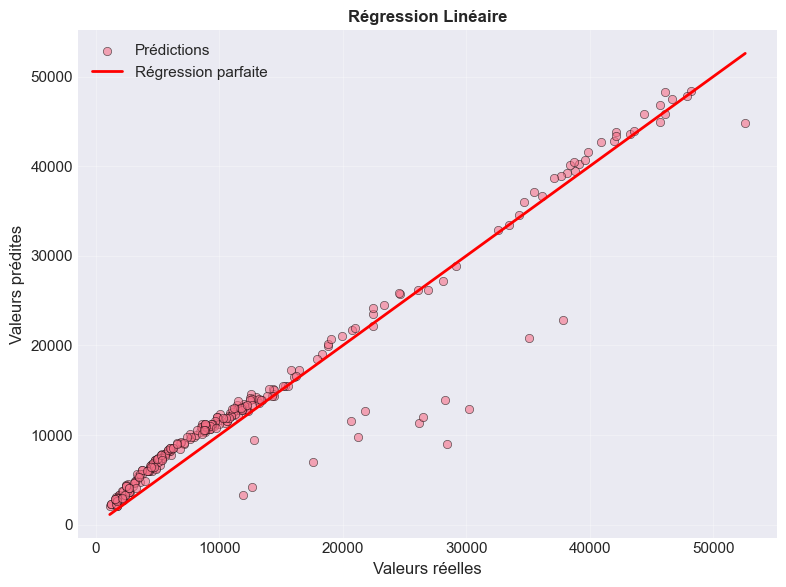

In [117]:
plot_regression_line(y_test, y_pred_test)

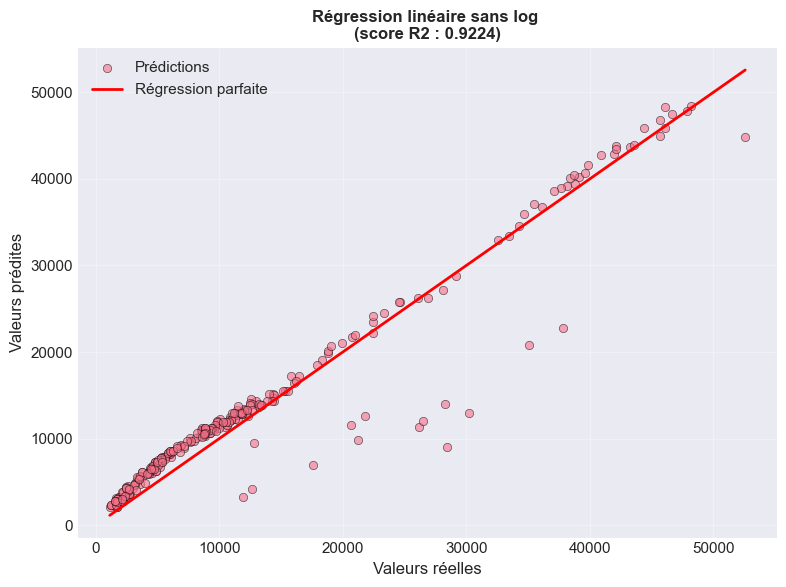

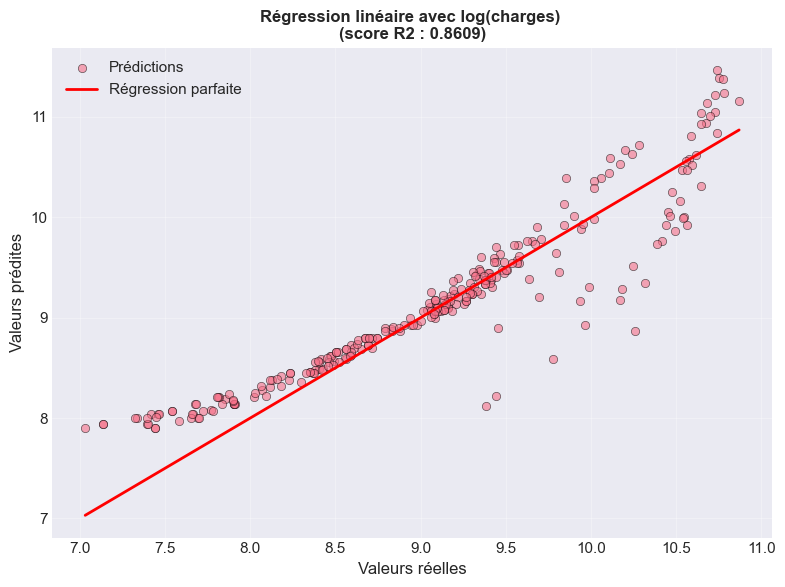

In [118]:
plot_regression_line(y_test, y_pred_test, f"Régression linéaire sans log \n(score R2 : {r2_score(y_test, y_pred_test):.4f})")
plot_regression_line(y_log_test, y_log_pred, f"Régression linéaire avec log(charges) \n(score R2 : {r2_score(y_log_test, y_log_pred):.4f})")

In [119]:
from sklearn.linear_model import Lasso


lasso_model = Lasso()

lasso_model.fit(X_train, y_train)

# Prédictions
y_pred_train = lasso_model.predict(X_train)
y_pred_test = lasso_model.predict(X_test)

# Évaluation
section("Performance du modèle Lasso :")
score_model(y_test, y_pred_test, 'test')
score_model(y_train, y_pred_train, 'train')



Performance du modèle Lasso :


Mesures de performance (test split) :


,R2,MAE,MSE
0,0.9224,2026.7494,3345.0661



Mesures de performance (train split) :


,R2,MAE,MSE
0,0.8519,2577.6637,4668.1174


- #### Pas de transformation logarithmique sur les charges
    - Nous avons déjà un modèle avec un bon score **0,92** et un bon MAE **2026,74 $**. Passer les charges en `log` faisait baisser ces valeurs.
    - Le `log` est souvent utilisé pour gérer les outliers, notre relation `bmi` - `smoker` crée une symétrie qui compense le problème des outliers des charges.
    - Conserver des données en `$` améliore la lisibilité des résultats sans passer par des calculs pouvant occasionner des problèmes de reconstitution.